In [1]:
# Imports

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

import gym

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [2]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
tf.version.VERSION

'2.9.1'

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}
save_interval = 5000  # @param {type:"integer"}

fc_layer_params = (100, 50)

In [5]:
def get_env():

    env = gym.make('CartPole-v1')
    return suite_gym.wrap_env(env)

env = get_env()

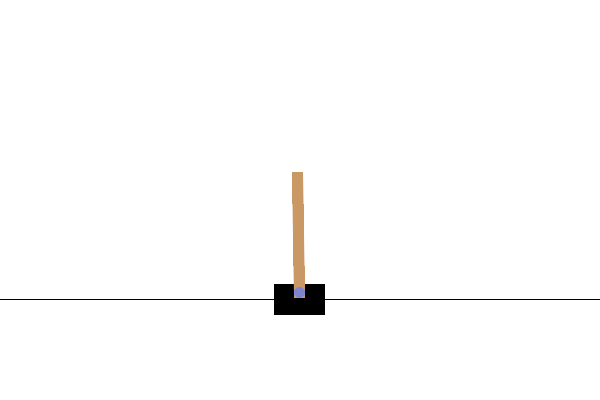

In [6]:
# generate sample image

env.reset()
PIL.Image.fromarray(env.render())

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01264504,  0.02047336, -0.00818995, -0.04241277], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01223557,  0.21571179, -0.00903821, -0.33766842], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [9]:
## Env setup

train_py_env = get_env()
eval_py_env = get_env()

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [10]:
## Construct network.

# fc_layer_params = (100, 50) # Moved to paramters section
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])


In [11]:
## Agent & Optimiser definition

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

2022-07-29 19:47:37.255200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:47:37.259624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:47:37.259856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:47:37.260632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
## avg return profiling

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [14]:
## random policy benchmark

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = tf_py_environment.TFPyEnvironment(
    get_env()
)

time_step = example_environment.reset()
random_policy.action(time_step)

random_policy_baseline = compute_avg_return(eval_env, random_policy, num_eval_episodes)

In [15]:
## Replay Buffer

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpe1xwmt4y.
[reverb/cc/platform/tfrecord_checkpointer.cc:552] Loading latest checkpoint from /tmp/tmpe1xwmt4y
[reverb/cc/platform/default/server.cc:71] Started replay server on port 43649


In [16]:
## PyDriver

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.02047994,  0.38307327, -0.07202084, -0.90301305], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [17]:
## Dataset from Replay Buffer

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)


In [18]:
## Video output

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  time_step = eval_env.reset()
  first_frame = eval_py_env.render()
  blank_frame = np.zeros_like(first_frame)
  blank_frame[:,:,0] = 255 # magenta

  filename = "videos/" + filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())

      # write 1 second of black frames between each episode  
      for i in range(fps): 
        video.append_data(blank_frame)
  return embed_mp4(filename)

In [19]:
# Clean video folder

!rm -rf videos
!mkdir videos

/usr/bin/zsh: /home/ibraheem/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/usr/bin/zsh: /home/ibraheem/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [20]:
## Training loop

try:
  %%time
except:
  pass

videos = []

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

print(f'Saving model video at step 0')
create_policy_eval_video(agent.policy, f"trained-agent-0")

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

  if step % save_interval == 0:
    print(f'Saving model video at step {step}')
    create_policy_eval_video(agent.policy, f"trained-agent-{step}")
    

Saving model video at step 0


[swscaler @ 0x55b3c147c9c0] Warning: data is not aligned! This can lead to a speed loss


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (25936) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=Fal

step = 1000: loss = 116.34452819824219
step = 1000: Average Return = 498.79998779296875
step = 2000: loss = 2648.21728515625
step = 2000: Average Return = 201.10000610351562
step = 3000: loss = 571.65625
step = 3000: Average Return = 127.30000305175781
step = 4000: loss = 18283.01953125
step = 4000: Average Return = 114.4000015258789
step = 5000: loss = 1807.302001953125


step = 5000: Average Return = 139.39999389648438
Saving model video at step 5000


[swscaler @ 0x5578305859c0] Warning: data is not aligned! This can lead to a speed loss


step = 6000: loss = 4162.3994140625
step = 6000: Average Return = 174.1999969482422
step = 7000: loss = 1584.6224365234375
step = 7000: Average Return = 230.0
step = 8000: loss = 34165.9765625
step = 8000: Average Return = 500.0
step = 9000: loss = 119636.109375
step = 9000: Average Return = 500.0
step = 10000: loss = 198690.359375


step = 10000: Average Return = 500.0
Saving model video at step 10000


[swscaler @ 0x55fb636169c0] Warning: data is not aligned! This can lead to a speed loss


step = 11000: loss = 96864.9609375
step = 11000: Average Return = 500.0
step = 12000: loss = 186674.75
step = 12000: Average Return = 500.0
step = 13000: loss = 891335.6875
step = 13000: Average Return = 500.0
step = 14000: loss = 337029.375
step = 14000: Average Return = 500.0
step = 15000: loss = 495254.1875


step = 15000: Average Return = 500.0
Saving model video at step 15000


[swscaler @ 0x55ee5dc759c0] Warning: data is not aligned! This can lead to a speed loss


step = 16000: loss = 4502247.0
step = 16000: Average Return = 496.70001220703125
step = 17000: loss = 690549.0
step = 17000: Average Return = 500.0
step = 18000: loss = 156832.953125
step = 18000: Average Return = 484.20001220703125
step = 19000: loss = 52378068.0
step = 19000: Average Return = 497.20001220703125
step = 20000: loss = 56118580.0


step = 20000: Average Return = 487.29998779296875
Saving model video at step 20000


[swscaler @ 0x5567d60ab9c0] Warning: data is not aligned! This can lead to a speed loss


Text(0.5, 0, 'Iterations')

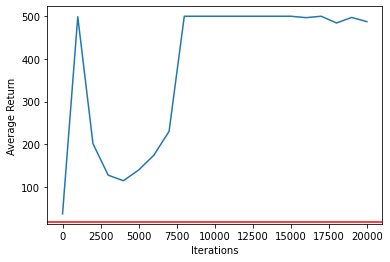

In [21]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.axhline(random_policy_baseline, color='red')
plt.ylabel('Average Return')
plt.xlabel('Iterations')